<a href="https://colab.research.google.com/github/kinghoon/Deep-Learning-for-project/blob/main/MFCC_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# wav(기본 데이터 학습) 학습 0.93 / 검증 0.95 / 예측 코로나 정확도 40%

In [ ]:
# 1.
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# 데이터 디렉토리
data_dir = '/content/drive/MyDrive/Colab Notebooks/wav'

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 22050 / hop_length))  # 5초 기준의 시퀀스 길이

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data():
    X, y = [], []
    class_labels = []
    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        if os.path.isfile(file_path) and file_path.endswith('.wav'):
            audio, sr = librosa.load(file_path, duration=duration, sr=None)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

            # MFCC 시퀀스 길이를 고정된 길이로 맞추기
            if mfcc.shape[1] < fixed_sequence_length:
                pad_width = fixed_sequence_length - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :fixed_sequence_length]

            X.append(mfcc)

            # 파일 이름의 첫 부분을 클래스 레이블로 사용
            class_label = file_name.split('(')[0]
            class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels = load_data()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # RNN은 3D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RNN 모델 정의
model = models.Sequential([
    layers.SimpleRNN(64, input_shape=(n_mfcc, fixed_sequence_length), return_sequences=True),
    layers.SimpleRNN(64),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/10
21/21 [==============================] - 5s 60ms/step - loss: 1.2818 - accuracy: 0.4404 - val_loss: 0.9731 - val_accuracy: 0.6145
Epoch 2/10
21/21 [==============================] - 1s 26ms/step - loss: 0.7450 - accuracy: 0.8054 - val_loss: 0.7166 - val_accuracy: 0.8072
Epoch 3/10
21/21 [==============================] - 1s 27ms/step - loss: 0.4695 - accuracy: 0.9276 - val_loss: 0.5289 - val_accuracy: 0.8735
Epoch 4/10
21/21 [==============================] - 1s 27ms/step - loss: 0.2904 - accuracy: 0.9804 - val_loss: 0.3827 - val_accuracy: 0.8795
Epoch 5/10
21/21 [==============================] - 1s 28ms/step - loss: 0.1731 - accuracy: 0.9849 - val_loss: 0.3038 - val_accuracy: 0.8916
Epoch 6/10
21/21 [==============================] - 1s 25ms/step - loss: 0.1051 - accuracy: 0.9910 - val_loss: 0.2324 - val_accuracy: 0.9277
Epoch 7/10
21/21 [==============================] - 1s 27ms/step - loss: 0.0651 - accuracy: 0.9925 - val_loss: 0.2056 - val_accuracy: 0.9458
Epoch 8/10
21

In [ ]:
# 기본 데이터셋 교차 검증
import os
import numpy as np
import librosa
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models

# 데이터 디렉토리
data_dir = '/content/drive/MyDrive/Colab Notebooks/wav'

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 22050 / hop_length))  # 5초 기준의 시퀀스 길이

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data():
    X, y = [], []
    class_labels = []
    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        if os.path.isfile(file_path) and file_path.endswith('.wav'):
            audio, sr = librosa.load(file_path, duration=duration, sr=None)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

            # MFCC 시퀀스 길이를 고정된 길이로 맞추기
            if mfcc.shape[1] < fixed_sequence_length:
                pad_width = fixed_sequence_length - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :fixed_sequence_length]

            X.append(mfcc)

            # 파일 이름의 첫 부분을 클래스 레이블로 사용
            class_label = file_name.split('(')[0]
            class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels = load_data()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # RNN은 3D 텐서를 입력으로 필요로 하므로 차원 추가

# 교차 검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 수행
fold_no = 1
fold_accuracies = []
fold_losses = []

for train_index, test_index in kf.split(X):
    print(f'Training fold {fold_no}...')

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # RNN 모델 정의
    model = models.Sequential([
        layers.SimpleRNN(64, input_shape=(n_mfcc, fixed_sequence_length), return_sequences=True),
        layers.SimpleRNN(64),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(class_labels), activation='softmax')
    ])

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 모델 학습
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    # 모델 평가
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Fold {fold_no} Test loss: {test_loss}')
    print(f'Fold {fold_no} Test accuracy: {test_acc}')

    fold_losses.append(test_loss)
    fold_accuracies.append(test_acc)

    fold_no += 1

# 교차 검증 결과 출력
mean_loss = np.mean(fold_losses)
mean_accuracy = np.mean(fold_accuracies)
print('Cross-validation mean loss:', mean_loss)
print('Cross-validation mean accuracy:', mean_accuracy)


Training fold 1...
Epoch 1/10
21/21 [==============================] - 4s 52ms/step - loss: 1.2396 - accuracy: 0.4676 - val_loss: 0.9786 - val_accuracy: 0.7470
Epoch 2/10
21/21 [==============================] - 1s 26ms/step - loss: 0.7306 - accuracy: 0.8658 - val_loss: 0.7081 - val_accuracy: 0.8554
Epoch 3/10
21/21 [==============================] - 1s 26ms/step - loss: 0.4435 - accuracy: 0.9502 - val_loss: 0.5040 - val_accuracy: 0.8916
Epoch 4/10
21/21 [==============================] - 1s 26ms/step - loss: 0.2562 - accuracy: 0.9774 - val_loss: 0.3413 - val_accuracy: 0.9036
Epoch 5/10
21/21 [==============================] - 0s 22ms/step - loss: 0.1410 - accuracy: 0.9879 - val_loss: 0.2377 - val_accuracy: 0.9337
Epoch 6/10
21/21 [==============================] - 0s 15ms/step - loss: 0.0828 - accuracy: 0.9879 - val_loss: 0.1794 - val_accuracy: 0.9458
Epoch 7/10
21/21 [==============================] - 0s 15ms/step - loss: 0.0508 - accuracy: 0.9940 - val_loss: 0.1442 - val_accuracy: 0

# 증강 데이터 학습 및 교차 검증(wav*7 wav + shift,time_stretch,white noise...)

Data shape: (5803, 20, 216)
Class labels: ['1', '2', '4', '3']
Class distribution: {'1': 770, '2': 1729, '4': 1708, '3': 1596}


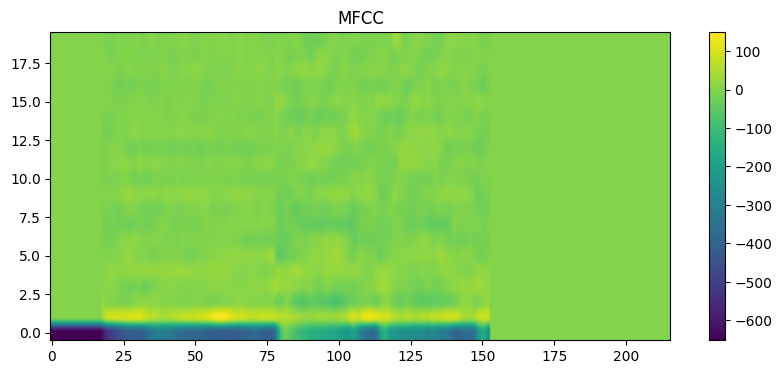

Epoch 1/20
146/146 [==============================] - 8s 27ms/step - loss: 1.2626 - accuracy: 0.4311 - val_loss: 0.8825 - val_accuracy: 0.6382
Epoch 2/20
146/146 [==============================] - 5s 31ms/step - loss: 0.9178 - accuracy: 0.6176 - val_loss: 0.7206 - val_accuracy: 0.7183
Epoch 3/20
146/146 [==============================] - 5s 35ms/step - loss: 0.7323 - accuracy: 0.7055 - val_loss: 0.6063 - val_accuracy: 0.7657
Epoch 4/20
146/146 [==============================] - 7s 48ms/step - loss: 0.5983 - accuracy: 0.7682 - val_loss: 0.5024 - val_accuracy: 0.8114
Epoch 5/20
146/146 [==============================] - 4s 30ms/step - loss: 0.5168 - accuracy: 0.8068 - val_loss: 0.4892 - val_accuracy: 0.8200
Epoch 6/20
146/146 [==============================] - 5s 34ms/step - loss: 0.4450 - accuracy: 0.8356 - val_loss: 0.3797 - val_accuracy: 0.8699
Epoch 7/20
146/146 [==============================] - 4s 25ms/step - loss: 0.3926 - accuracy: 0.8580 - val_loss: 0.3913 - val_accuracy: 0.8587

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# 데이터 디렉토리
data_dir = '/content/drive/MyDrive/Colab Notebooks/audio_augmentation2'

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 22050 / hop_length))  # 5초 기준의 시퀀스 길이

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data():
    X, y = [], []
    class_labels = []
    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        if os.path.isfile(file_path) and file_path.endswith('.wav'):
            audio, sr = librosa.load(file_path, duration=duration, sr=22050)  # sr을 고정된 값으로 설정
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

            # MFCC 시퀀스 길이를 고정된 길이로 맞추기
            if mfcc.shape[1] < fixed_sequence_length:
                pad_width = fixed_sequence_length - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :fixed_sequence_length]

            X.append(mfcc)

            # 파일 이름의 첫 부분을 클래스 레이블로 사용
            class_label = file_name.split('(')[0]
            class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels_unique = load_data()

# 데이터 크기 및 분포 확인
print(f'Data shape: {X.shape}')
print(f'Class labels: {class_labels_unique}')

# 각 클래스의 데이터 개수 확인
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(class_labels_unique, counts))
print(f'Class distribution: {class_counts}')

# 데이터 시각화
plt.figure(figsize=(10, 4))
plt.imshow(X[0].squeeze(), aspect='auto', origin='lower')
plt.title('MFCC')
plt.colorbar()
plt.show()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # RNN은 3D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RNN 모델 정의
model = models.Sequential([
    layers.SimpleRNN(128, input_shape=(n_mfcc, fixed_sequence_length), return_sequences=True),
    layers.Dropout(0.3),
    layers.SimpleRNN(128),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_labels_unique), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)




In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models

# 데이터 디렉토리
data_dir = '/content/drive/MyDrive/Colab Notebooks/learning_data'

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 22050 / hop_length))  # 5초 기준의 시퀀스 길이

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data():
    X, y = [], []
    class_labels = []
    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        if os.path.isfile(file_path) and file_path.endswith('.wav'):
            audio, sr = librosa.load(file_path, duration=duration, sr=22050)  # sr을 고정된 값으로 설정
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

            # MFCC 시퀀스 길이를 고정된 길이로 맞추기
            if mfcc.shape[1] < fixed_sequence_length:
                pad_width = fixed_sequence_length - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :fixed_sequence_length]

            X.append(mfcc)

            # 파일 이름의 첫 부분을 클래스 레이블로 사용
            class_label = file_name.split('(')[0]
            class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels_unique = load_data()

# 데이터 크기 및 분포 확인
print(f'Data shape: {X.shape}')
print(f'Class labels: {class_labels_unique}')

# 각 클래스의 데이터 개수 확인
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(class_labels_unique, counts))
print(f'Class distribution: {class_counts}')

# 교차 검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 수행
fold_no = 1
fold_accuracies = []
fold_losses = []

for train_index, test_index in kf.split(X):
    print(f'Training fold {fold_no}...')

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # RNN 모델 정의
    model = models.Sequential([
        layers.SimpleRNN(128, input_shape=(n_mfcc, fixed_sequence_length), return_sequences=True),
        layers.Dropout(0.3),
        layers.SimpleRNN(128),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(len(class_labels_unique), activation='softmax')
    ])

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 모델 학습
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # 모델 평가
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Fold {fold_no} Test loss: {test_loss}')
    print(f'Fold {fold_no} Test accuracy: {test_acc}')

    fold_losses.append(test_loss)
    fold_accuracies.append(test_acc)

    fold_no += 1

# 교차 검증 결과 출력
mean_loss = np.mean(fold_losses)
mean_accuracy = np.mean(fold_accuracies)
print('Cross-validation mean loss:', mean_loss)
print('Cross-validation mean accuracy:', mean_accuracy)


Data shape: (5803, 20, 216)
Class labels: ['1', '2', '4', '3']
Class distribution: {'1': 770, '2': 1729, '4': 1708, '3': 1596}
Training fold 1...
Epoch 1/20
146/146 [==============================] - 7s 31ms/step - loss: 1.3028 - accuracy: 0.4255 - val_loss: 0.9212 - val_accuracy: 0.6270
Epoch 2/20
146/146 [==============================] - 6s 42ms/step - loss: 0.9186 - accuracy: 0.6206 - val_loss: 0.7066 - val_accuracy: 0.7192
Epoch 3/20
146/146 [==============================] - 6s 41ms/step - loss: 0.7477 - accuracy: 0.7090 - val_loss: 0.5607 - val_accuracy: 0.7941
Epoch 4/20
146/146 [==============================] - 7s 49ms/step - loss: 0.6158 - accuracy: 0.7538 - val_loss: 0.5235 - val_accuracy: 0.8105
Epoch 5/20
146/146 [==============================] - 8s 52ms/step - loss: 0.5469 - accuracy: 0.7852 - val_loss: 0.4475 - val_accuracy: 0.8363
Epoch 6/20
146/146 [==============================] - 8s 58ms/step - loss: 0.4581 - accuracy: 0.8274 - val_loss: 0.4225 - val_accuracy: 0.8

In [ ]:
import os
import numpy as np
import librosa
import warnings
from tensorflow.keras import models
from collections import Counter

# 경고 무시 설정
warnings.filterwarnings('ignore', category=UserWarning, module='librosa')
warnings.filterwarnings('ignore', category=FutureWarning, module='librosa')

# 모델 로드
model = models.load_model('/content/drive/MyDrive/Colab Notebooks/saved_model/0604_augmentation(mfcc).keras')

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이 (이 값은 기존에 사용한 것과 동일해야 함)
fixed_sequence_length = int(np.ceil(duration * 22050 / hop_length))  # 5초 기준의 시퀀스 길이

# 클래스 레이블 (기존에 사용한 클래스 레이블 순서와 동일하게 유지해야 함)
class_labels = ['천식', '정상', '코로나', '심부전증']  # 실제 클래스 이름으로 대체하세요.

def preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, duration=duration, sr=22050)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # MFCC 시퀀스 길이를 고정된 길이로 맞추기
    if mfcc.shape[1] < fixed_sequence_length:
        pad_width = fixed_sequence_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :fixed_sequence_length]

    mfcc = np.expand_dims(mfcc, axis=-1)  # RNN은 3D 텐서를 입력으로 필요로 하므로 차원 추가
    mfcc = np.expand_dims(mfcc, axis=0)  # 배치 차원 추가

    return mfcc

def predict(file_path):
    mfcc = preprocess_audio(file_path)
    prediction = model.predict(mfcc)
    predicted_index = np.argmax(prediction)
    if predicted_index < len(class_labels):
        predicted_class = class_labels[predicted_index]
    else:
        predicted_class = "Unknown"
    return predicted_class

# 예측 수행
def predict_directory(directory_path):
    predictions = {}
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(directory_path, file_name)
            predicted_class = predict(file_path)
            predictions[file_name] = predicted_class
            print(f'The predicted class for {file_name} is: {predicted_class}')
    return predictions

def print_statistics(predictions):
    count = Counter(predictions.values())
    total_predictions = sum(count.values())

    print("\nPrediction Statistics:")
    for cls in class_labels:
        print(f'{cls}: {count[cls]} ({(count[cls] / total_predictions) * 100:.2f}%)')
    print(f'Unknown: {count["Unknown"]} ({(count["Unknown"] / total_predictions) * 100:.2f}%)')

# 디렉토리 내 모든 WAV 파일에 대해 예측 수행
directory_path = '/content/drive/MyDrive/Colab Notebooks/voicedata/covid light'
predictions = predict_directory(directory_path)

# 예측 통계 출력
print_statistics(predictions)


1/1 [==============================] - 1s 887ms/step
The predicted class for 3(1075).wav is: 천식
1/1 [==============================] - 0s 55ms/step
The predicted class for 3(1076).wav is: 천식
1/1 [==============================] - 0s 73ms/step
The predicted class for 3(1077).wav is: 천식
1/1 [==============================] - 0s 49ms/step
The predicted class for 3(1078).wav is: 정상
1/1 [==============================] - 0s 48ms/step
The predicted class for 3(1079).wav is: 정상
1/1 [==============================] - 0s 45ms/step
The predicted class for 3(1080).wav is: 심부전증
1/1 [==============================] - 0s 55ms/step
The predicted class for 3(1081).wav is: 천식
1/1 [==============================] - 0s 41ms/step
The predicted class for 3(1082).wav is: 천식
1/1 [==============================] - 0s 47ms/step
The predicted class for 3(1083).wav is: 천식
1/1 [==============================] - 0s 53ms/step
The predicted class for 3(1084).wav is: 천식
1/1 [==============================] - 0s 47ms/

<ipython-input-13-e172e6373b37>:39: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, duration=duration, sr=22050)  # sr을 고정된 값으로 설정
<ipython-input-13-e172e6373b37>:39: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, duration=duration, sr=22050)  # sr을 고정된 값으로 설정
<ipython-input-13-e172e6373b37>:39: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, duration=duration, sr=22050)  # sr을 고정된 값으로 설정
<ipython-input-13-e172e6373b37>:39: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, duration=duration, sr=22050)  # sr을 고정된 값으로 설정
<ipython-input-13-e172e6373b37>:39: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, duration=duration, sr=22050)  # sr을 고정된 값으로 설정
<ipython-input-13-e172e6373b37>:39: UserWarning: PySoundFile failed. Trying audioread instead.
  aud

Data shape: (2665, 20, 431)
Class labels: ['3', '1', '2', '4']
Class distribution: {'3': 640, '1': 770, '2': 523, '4': 732}


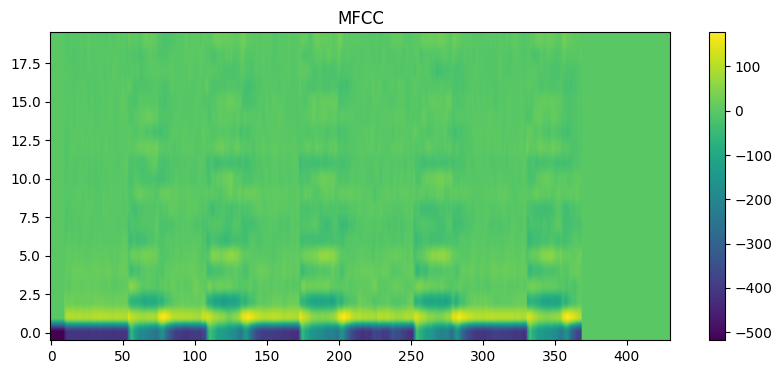

Epoch 1/20
67/67 [==============================] - 4s 31ms/step - loss: 1.3291 - accuracy: 0.4231 - val_loss: 0.9685 - val_accuracy: 0.6041
Epoch 2/20
67/67 [==============================] - 2s 26ms/step - loss: 1.0151 - accuracy: 0.5905 - val_loss: 0.8477 - val_accuracy: 0.6567
Epoch 3/20
67/67 [==============================] - 3s 40ms/step - loss: 0.8352 - accuracy: 0.6553 - val_loss: 0.7908 - val_accuracy: 0.6754
Epoch 4/20
67/67 [==============================] - 5s 70ms/step - loss: 0.6575 - accuracy: 0.7378 - val_loss: 0.7120 - val_accuracy: 0.7036
Epoch 5/20
67/67 [==============================] - 3s 48ms/step - loss: 0.5628 - accuracy: 0.7735 - val_loss: 0.5975 - val_accuracy: 0.7786
Epoch 6/20
67/67 [==============================] - 3s 47ms/step - loss: 0.4809 - accuracy: 0.8180 - val_loss: 0.5629 - val_accuracy: 0.7936
Epoch 7/20
67/67 [==============================] - 2s 30ms/step - loss: 0.4382 - accuracy: 0.8302 - val_loss: 0.6013 - val_accuracy: 0.7899
Epoch 8/20
67

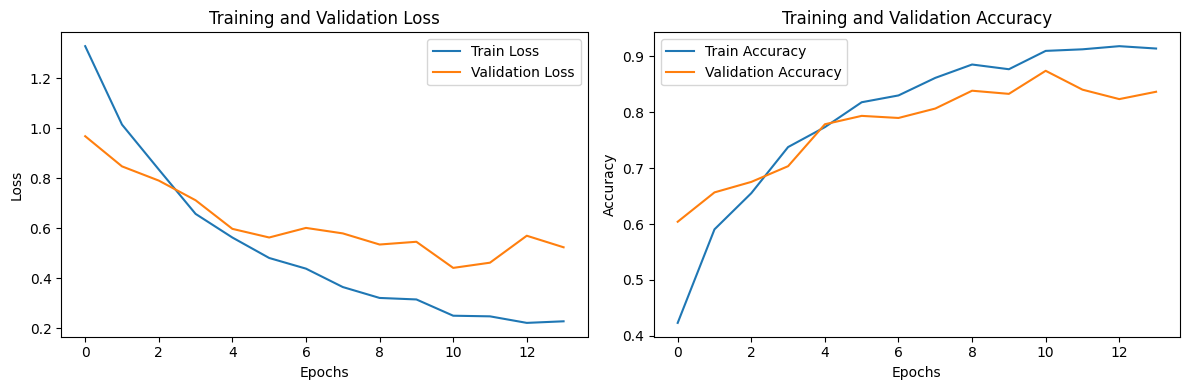

17/17 [==============================] - 0s 9ms/step - loss: 0.4412 - accuracy: 0.8743
Test accuracy: 0.8742964267730713


In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# 여러 개의 데이터 디렉토리
data_dirs = [
    '/content/drive/MyDrive/Colab Notebooks/voicedata/wav',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/augmentation/4',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/augmentation/1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid3',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid4',
    # 필요에 따라 추가 디렉토리를 여기에 추가
]

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 22050 / hop_length))  # 초 기준의 시퀀스 길이

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data(data_dirs):
    X, y = [], []
    class_labels = []

    for data_dir in data_dirs:
        for file_name in os.listdir(data_dir):
            file_path = os.path.join(data_dir, file_name)
            if os.path.isfile(file_path) and file_path.endswith('.wav'):
                try:
                    audio, sr = librosa.load(file_path, duration=duration, sr=22050)  # sr을 고정된 값으로 설정
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

                # MFCC 시퀀스 길이를 고정된 길이로 맞추기
                if mfcc.shape[1] < fixed_sequence_length:
                    pad_width = fixed_sequence_length - mfcc.shape[1]
                    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    mfcc = mfcc[:, :fixed_sequence_length]

                X.append(mfcc)

                # 파일 이름의 첫 부분을 클래스 레이블로 사용
                class_label = file_name.split('(')[0]
                class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels_unique = load_data(data_dirs)

# 데이터 크기 및 분포 확인
print(f'Data shape: {X.shape}')
print(f'Class labels: {class_labels_unique}')

# 각 클래스의 데이터 개수 확인
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(class_labels_unique, counts))
print(f'Class distribution: {class_counts}')

# 데이터 시각화
plt.figure(figsize=(10, 4))
plt.imshow(X[0].squeeze(), aspect='auto', origin='lower')
plt.title('MFCC')
plt.colorbar()
plt.show()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # RNN은 3D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# RNN 모델 정의
model = models.Sequential([
    layers.SimpleRNN(128, input_shape=(n_mfcc, fixed_sequence_length), return_sequences=True),
    layers.Dropout(0.3),
    layers.SimpleRNN(128),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_labels_unique), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 학습 곡선 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# 학습된 모델 저장
# model.save('/content/drive/MyDrive/Colab Notebooks/saved_model/my_model.h5')


In [ ]:
!pip install soundfile


# (기본+healthy,증강(천식,심부전),covid)여러 디렉토리 학습

Data shape: (2939, 20, 431)
Class labels: ['3', '1', '4', '2']
Class distribution: {'3': 638, '1': 770, '4': 732, '2': 799}


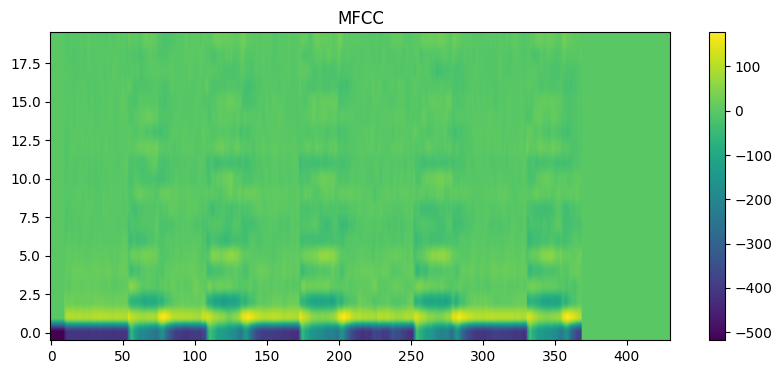

Epoch 1/20
74/74 [==============================] - 6s 41ms/step - loss: 1.3633 - accuracy: 0.4054 - val_loss: 1.0582 - val_accuracy: 0.5391
Epoch 2/20
74/74 [==============================] - 3s 44ms/step - loss: 1.0452 - accuracy: 0.5542 - val_loss: 0.9064 - val_accuracy: 0.6378
Epoch 3/20
74/74 [==============================] - 2s 32ms/step - loss: 0.8651 - accuracy: 0.6312 - val_loss: 0.7781 - val_accuracy: 0.6854
Epoch 4/20
74/74 [==============================] - 2s 27ms/step - loss: 0.7362 - accuracy: 0.7065 - val_loss: 0.6588 - val_accuracy: 0.7738
Epoch 5/20
74/74 [==============================] - 2s 25ms/step - loss: 0.6207 - accuracy: 0.7601 - val_loss: 0.6651 - val_accuracy: 0.7755
Epoch 6/20
74/74 [==============================] - 2s 28ms/step - loss: 0.5272 - accuracy: 0.8014 - val_loss: 0.5647 - val_accuracy: 0.8146
Epoch 7/20
74/74 [==============================] - 2s 25ms/step - loss: 0.4675 - accuracy: 0.8171 - val_loss: 0.5602 - val_accuracy: 0.8197
Epoch 8/20
74

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import warnings

# 경고 메시지 억제
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 여러 개의 데이터 디렉토리
data_dirs = [
    '/content/drive/MyDrive/Colab Notebooks/voicedata/wav',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy2',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/augmentation/4',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/augmentation/1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid2',
    # 필요에 따라 추가 디렉토리를 여기에 추가
]

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 22050 / hop_length))  # 초 기준의 시퀀스 길이

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data(data_dirs):
    X, y = [], []
    class_labels = []

    for data_dir in data_dirs:
        for file_name in os.listdir(data_dir):
            file_path = os.path.join(data_dir, file_name)
            if os.path.isfile(file_path) and file_path.endswith('.wav'):
                try:
                    audio, sr = librosa.load(file_path, duration=duration, sr=22050)  # sr을 고정된 값으로 설정
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

                # MFCC 시퀀스 길이를 고정된 길이로 맞추기
                if mfcc.shape[1] < fixed_sequence_length:
                    pad_width = fixed_sequence_length - mfcc.shape[1]
                    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    mfcc = mfcc[:, :fixed_sequence_length]

                X.append(mfcc)

                # 파일 이름의 첫 부분을 클래스 레이블로 사용
                class_label = file_name.split('(')[0]
                class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels_unique = load_data(data_dirs)

# 데이터 크기 및 분포 확인
print(f'Data shape: {X.shape}')
print(f'Class labels: {class_labels_unique}')

# 각 클래스의 데이터 개수 확인
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(class_labels_unique, counts))
print(f'Class distribution: {class_counts}')

# 데이터 시각화
plt.figure(figsize=(10, 4))
plt.imshow(X[0].squeeze(), aspect='auto', origin='lower')
plt.title('MFCC')
plt.colorbar()
plt.show()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # RNN은 3D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RNN 모델 정의
model = models.Sequential([
    layers.SimpleRNN(128, input_shape=(n_mfcc, fixed_sequence_length), return_sequences=True),
    layers.Dropout(0.3),
    layers.SimpleRNN(128),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_labels_unique), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


# 학습 후 모델 저장

# import keras

# keras.saving.save_model(model, '/content/drive/MyDrive/Colab Notebooks/saved_model/0607_analyzer.keras')


In [ ]:
import os
import numpy as np
import soundfile as sf
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
from collections import Counter

# 모델 로드
# model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/saved_model/my_model.h5')

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = 431  # 모델 학습 시 사용한 값으로 설정

# 클래스 레이블 리스트 (모델 학습 시 사용한 것과 동일해야 함)
class_labels_unique = ['코로나', '천식', '심부전', '정상']  # 실제 클래스 레이블로 변경

# 새로운 데이터 예측 함수
def predict_new_data(file_path):
    try:
        try:
            audio, sr = sf.read(file_path, dtype='float32')
            if len(audio.shape) > 1:
                audio = np.mean(audio, axis=1)  # 다중 채널 오디오의 경우 평균값 사용
        except RuntimeError:
            audio, sr = librosa.load(file_path, sr=None, mono=True)
            if len(audio.shape) > 1:
                audio = np.mean(audio, axis=1)  # 다중 채널 오디오의 경우 평균값 사용

        if sr != 22050:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=22050)

        if len(audio) < duration * 22050:
            audio = np.pad(audio, (0, duration * 22050 - len(audio)), mode='constant')
        else:
            audio = audio[:duration * 22050]

        mfcc = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

        if mfcc.shape[1] < fixed_sequence_length:
            pad_width = fixed_sequence_length - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :fixed_sequence_length]

        mfcc = np.expand_dims(mfcc, axis=0)
        mfcc = np.expand_dims(mfcc, axis=-1)

        prediction = model.predict(mfcc)
        predicted_class = np.argmax(prediction, axis=1)

        return class_labels_unique[predicted_class[0]]
    except Exception as e:
        print(f"Error predicting {file_path}: {e}")
        return None

# 폴더 내 모든 파일 예측 함수
def predict_all_files_in_folder(folder_path):
    results = {}
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path) and file_path.endswith('.wav'):
            predicted_label = predict_new_data(file_path)
            results[file_name] = predicted_label
    return results

# 예측할 폴더 경로
folder_path = '/content/drive/MyDrive/Colab Notebooks/voicedata/test_light'  # 예측할 폴더 경로

# 폴더 내 모든 파일 예측
all_predictions = predict_all_files_in_folder(folder_path)

# 예측 결과 출력
for file_name, predicted_label in all_predictions.items():
    print(f'{file_name}: {predicted_label}')

# 예측 결과 통계 출력
def print_statistics(predictions):
    count = Counter(predictions.values())
    total_predictions = sum(count.values())

    print("\nPrediction Statistics:")
    for cls in class_labels_unique:
        print(f'{cls}: {count[cls]} ({(count[cls] / total_predictions) * 100:.2f}%)')
    print(f'Unknown: {count[None]} ({(count[None] / total_predictions) * 100:.2f}%)')

# 예측 결과 통계 출력
print_statistics(all_predictions)


1/1 [==============================] - 0s 35ms/step
file_863.wav: 코로나
file_864.wav: 코로나
file_865.wav: 코로나
file_866.wav: 코로나
file_867.wav: 코로나
file_868.wav: 코로나
file_869.wav: 코로나
file_870.wav: 코로나
file_871.wav: 코로나
file_872.wav: 정상
file_873.wav: 코로나
file_874.wav: 정상
file_875.wav: 코로나
file_876.wav: 코로나
file_877.wav: 코로나
file_878.wav: 코로나
file_879.wav: 코로나
file_880.wav: 코로나
file_881.wav: 코로나
file_882.wav: 코로나
file_883.wav: 코로나
file_884.wav: 정상
file_885.wav: 코로나
file_886.wav: 코로나
file_887.wav: 코로나
file_888.wav: 코로나
file_889.wav: 코로나
file_890.wav: 코로나
file_891.wav: 코로나
file_892.wav: 정상
file_893.wav: 정상
file_894.wav: 코로나
file_895.wav: 코로나
file_896.wav: 코로나
file_897.wav: 코로나
file_898.wav: 정상
file_899.wav: 정상
file_900.wav: 천식
file_901.wav: 코로나
file_902.wav: 코로나
file_903.wav: 코로나
file_904.wav: 코로나
file_905.wav: 코로나
file_906.wav: 정상
file_907.wav: 코로나
file_908.wav: 코로나
file_909.wav: 코로나
file_910.wav: 코로나
file_911.wav: 코로나
file_912.wav: 코로나
file_913.wav: 코로나
file_914.wav: 코로나
file_915.wav: 코로나
fil

# 테스트 코드

Data shape: (2941, 20, 431)
Class labels: ['3', '1', '4', '2']
Class distribution: {'3': 638, '1': 770, '4': 732, '2': 801}


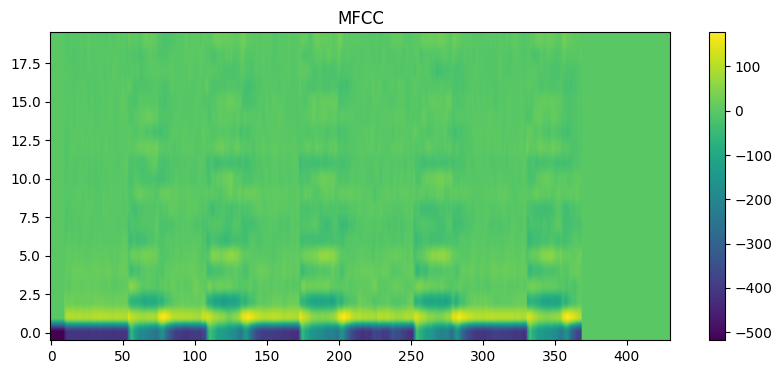

Epoch 1/20
74/74 [==============================] - 46s 600ms/step - loss: 4.0463 - accuracy: 0.6220 - val_loss: 0.6294 - val_accuracy: 0.7691
Epoch 2/20
74/74 [==============================] - 43s 589ms/step - loss: 0.4807 - accuracy: 0.8172 - val_loss: 0.4048 - val_accuracy: 0.8455
Epoch 3/20
74/74 [==============================] - 42s 568ms/step - loss: 0.2995 - accuracy: 0.8848 - val_loss: 0.2533 - val_accuracy: 0.8998
Epoch 4/20
74/74 [==============================] - 46s 629ms/step - loss: 0.1943 - accuracy: 0.9320 - val_loss: 0.2174 - val_accuracy: 0.9253
Epoch 5/20
74/74 [==============================] - 44s 602ms/step - loss: 0.1311 - accuracy: 0.9537 - val_loss: 0.2791 - val_accuracy: 0.9236
Epoch 6/20
74/74 [==============================] - 51s 686ms/step - loss: 0.0986 - accuracy: 0.9588 - val_loss: 0.3649 - val_accuracy: 0.8846
Epoch 7/20
74/74 [==============================] - 44s 601ms/step - loss: 0.1280 - accuracy: 0.9558 - val_loss: 0.1680 - val_accuracy: 0.9525

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import warnings

# 경고 메시지 억제
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 여러 개의 데이터 디렉토리
data_dirs = [
    '/content/drive/MyDrive/Colab Notebooks/voicedata/wav',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy2',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/augmentation/4',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/augmentation/1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid2',
    # 필요에 따라 추가 디렉토리를 여기에 추가
]

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 22050 / hop_length))  # 초 기준의 시퀀스 길이

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data(data_dirs):
    X, y = [], []
    class_labels = []

    for data_dir in data_dirs:
        for file_name in os.listdir(data_dir):
            file_path = os.path.join(data_dir, file_name)
            if os.path.isfile(file_path) and file_path.endswith('.wav'):
                try:
                    audio, sr = librosa.load(file_path, duration=duration, sr=22050)  # sr을 고정된 값으로 설정
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

                # MFCC 시퀀스 길이를 고정된 길이로 맞추기
                if mfcc.shape[1] < fixed_sequence_length:
                    pad_width = fixed_sequence_length - mfcc.shape[1]
                    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    mfcc = mfcc[:, :fixed_sequence_length]

                X.append(mfcc)

                # 파일 이름의 첫 부분을 클래스 레이블로 사용
                class_label = file_name.split('(')[0]
                class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels_unique = load_data(data_dirs)

# 데이터 크기 및 분포 확인
print(f'Data shape: {X.shape}')
print(f'Class labels: {class_labels_unique}')

# 각 클래스의 데이터 개수 확인
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(class_labels_unique, counts))
print(f'Class distribution: {class_counts}')

# 데이터 시각화
plt.figure(figsize=(10, 4))
plt.imshow(X[0].squeeze(), aspect='auto', origin='lower')
plt.title('MFCC')
plt.colorbar()
plt.show()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # CNN은 4D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN 모델 정의
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(n_mfcc, fixed_sequence_length, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_labels_unique), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)




In [ ]:
# 학습 후 모델 저장
model.save('/content/drive/MyDrive/Colab Notebooks/saved_model/0607_crazy_model.keras')

# ↑테스트

In [ ]:
# 1-1. 기본 데이터셋에 드롭아웃 적용
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# 데이터 디렉토리
data_dir = '/content/drive/MyDrive/Colab Notebooks/voicedata/wav'

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 22050 / hop_length))  # 5초 기준의 시퀀스 길이

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data():
    X, y = [], []
    class_labels = []
    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        if os.path.isfile(file_path) and file_path.endswith('.wav'):
            audio, sr = librosa.load(file_path, duration=duration, sr=None)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

            # MFCC 시퀀스 길이를 고정된 길이로 맞추기
            if mfcc.shape[1] < fixed_sequence_length:
                pad_width = fixed_sequence_length - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :fixed_sequence_length]

            X.append(mfcc)

            # 파일 이름의 첫 부분을 클래스 레이블로 사용
            class_label = file_name.split('(')[0]
            class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels = load_data()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # RNN은 3D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RNN 모델 정의
model = models.Sequential([
    layers.SimpleRNN(64, input_shape=(n_mfcc, fixed_sequence_length), return_sequences=True),
    layers.Dropout(0.5),
    layers.SimpleRNN(64),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_labels), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/10
21/21 [==============================] - 4s 51ms/step - loss: 1.6878 - accuracy: 0.2900 - val_loss: 1.3530 - val_accuracy: 0.3253
Epoch 2/10
21/21 [==============================] - 0s 22ms/step - loss: 1.6523 - accuracy: 0.3051 - val_loss: 1.2617 - val_accuracy: 0.4699
Epoch 3/10
21/21 [==============================] - 0s 23ms/step - loss: 1.5669 - accuracy: 0.3248 - val_loss: 1.2299 - val_accuracy: 0.4337
Epoch 4/10
21/21 [==============================] - 0s 22ms/step - loss: 1.4597 - accuracy: 0.3701 - val_loss: 1.2068 - val_accuracy: 0.4819
Epoch 5/10
21/21 [==============================] - 0s 23ms/step - loss: 1.4757 - accuracy: 0.3746 - val_loss: 1.1877 - val_accuracy: 0.5241
Epoch 6/10
21/21 [==============================] - 1s 27ms/step - loss: 1.3949 - accuracy: 0.3610 - val_loss: 1.1442 - val_accuracy: 0.5482
Epoch 7/10
21/21 [==============================] - 1s 24ms/step - loss: 1.4103 - accuracy: 0.3716 - val_loss: 1.1625 - val_accuracy: 0.5241
Epoch 8/10
21

Training fold 1...
Epoch 1/10
21/21 [==============================] - 5s 34ms/step - loss: 1.9502 - accuracy: 0.2402 - val_loss: 1.3798 - val_accuracy: 0.3554
Epoch 2/10
21/21 [==============================] - 0s 14ms/step - loss: 1.7010 - accuracy: 0.2961 - val_loss: 1.2690 - val_accuracy: 0.4036
Epoch 3/10
21/21 [==============================] - 0s 16ms/step - loss: 1.6500 - accuracy: 0.3338 - val_loss: 1.1986 - val_accuracy: 0.4458
Epoch 4/10
21/21 [==============================] - 0s 13ms/step - loss: 1.4499 - accuracy: 0.3822 - val_loss: 1.1634 - val_accuracy: 0.5000
Epoch 5/10
21/21 [==============================] - 0s 17ms/step - loss: 1.4127 - accuracy: 0.3897 - val_loss: 1.1369 - val_accuracy: 0.5422
Epoch 6/10
21/21 [==============================] - 0s 16ms/step - loss: 1.4319 - accuracy: 0.3716 - val_loss: 1.1098 - val_accuracy: 0.5602
Epoch 7/10
21/21 [==============================] - 0s 14ms/step - loss: 1.3480 - accuracy: 0.3776 - val_loss: 1.0925 - val_accuracy: 0

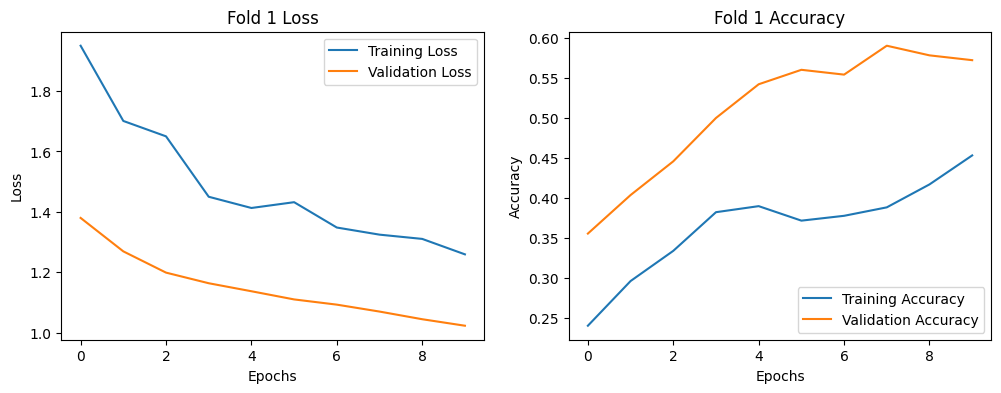

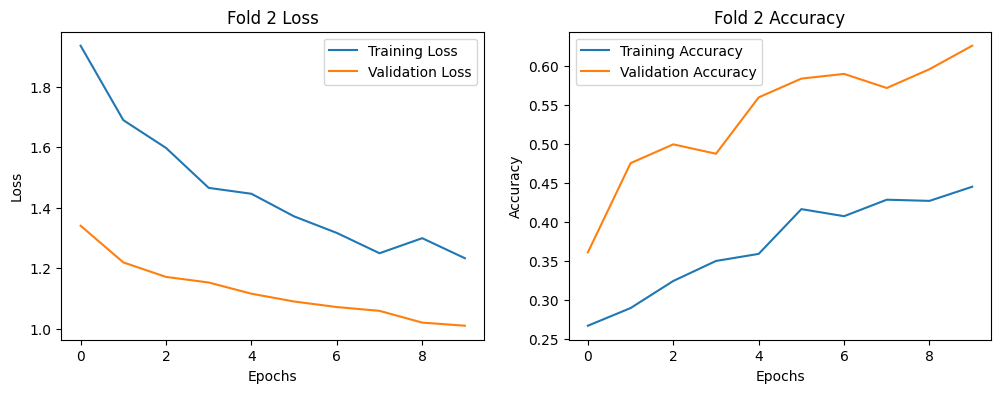

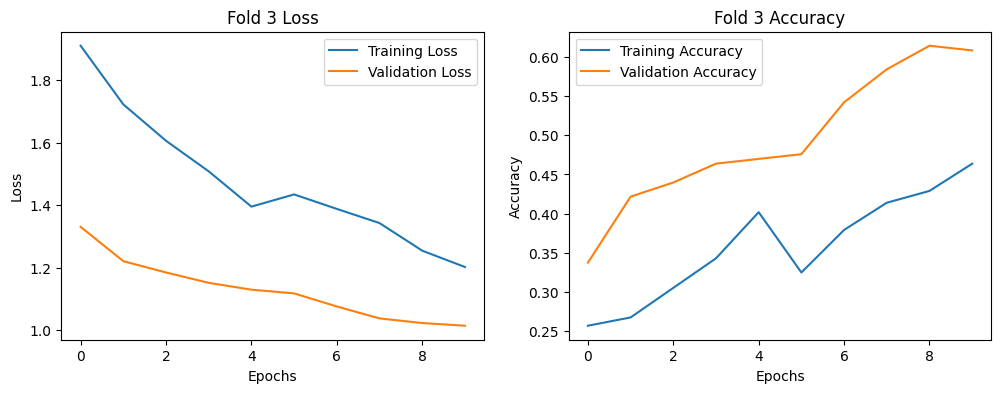

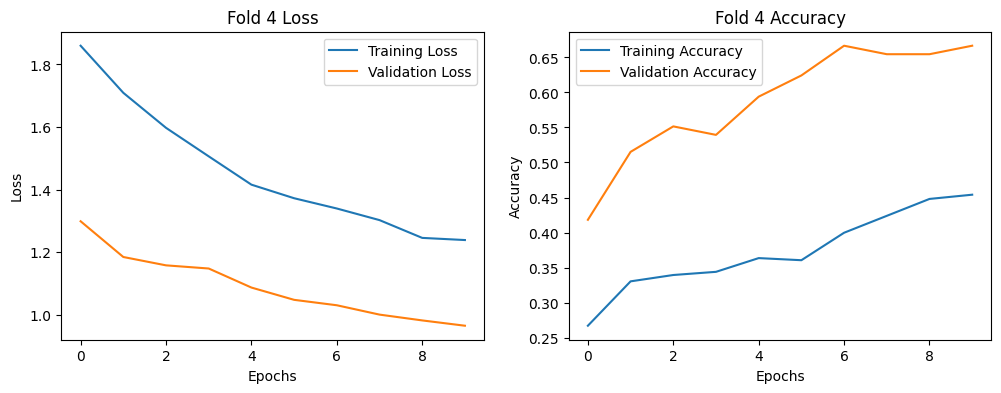

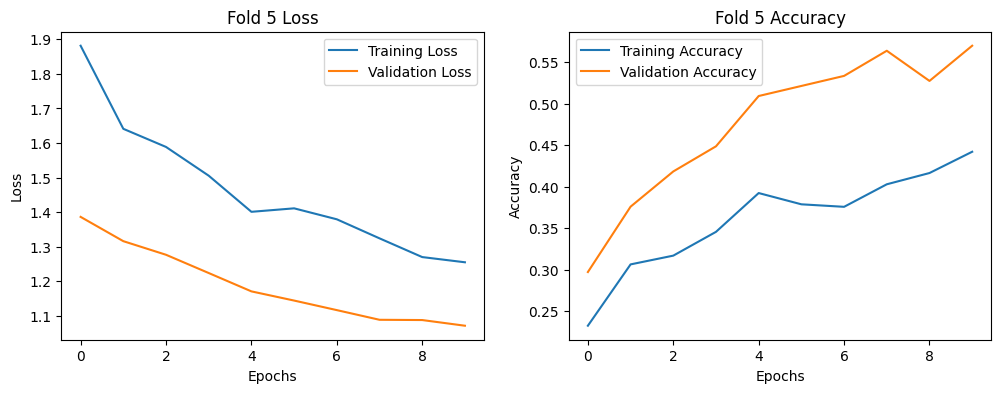

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models

# 데이터 디렉토리
data_dir = '/content/drive/MyDrive/Colab Notebooks/voicedata/wav'

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 22050 / hop_length))  # 5초 기준의 시퀀스 길이

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data():
    X, y = [], []
    class_labels = []
    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        if os.path.isfile(file_path) and file_path.endswith('.wav'):
            audio, sr = librosa.load(file_path, duration=duration, sr=None)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

            # MFCC 시퀀스 길이를 고정된 길이로 맞추기
            if mfcc.shape[1] < fixed_sequence_length:
                pad_width = fixed_sequence_length - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :fixed_sequence_length]

            X.append(mfcc)

            # 파일 이름의 첫 부분을 클래스 레이블로 사용
            class_label = file_name.split('(')[0]
            class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels = load_data()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # RNN은 3D 텐서를 입력으로 필요로 하므로 차원 추가

# 교차 검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 수행
fold_no = 1
fold_accuracies = []
histories = []

for train_index, test_index in kf.split(X):
    print(f'Training fold {fold_no}...')

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # RNN 모델 정의
    model = models.Sequential([
        layers.SimpleRNN(64, input_shape=(n_mfcc, fixed_sequence_length), return_sequences=True),
        layers.Dropout(0.5),  # Dropout 적용
        layers.SimpleRNN(64),
        layers.Dropout(0.5),  # Dropout 적용
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),  # Dropout 적용
        layers.Dense(len(class_labels), activation='softmax')
    ])

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 모델 학습
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    histories.append(history)

    # 모델 평가
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Fold {fold_no} Test accuracy:', test_acc)
    fold_accuracies.append(test_acc)

    fold_no += 1

# 교차 검증 결과 출력
mean_accuracy = np.mean(fold_accuracies)
print('Cross-validation mean accuracy:', mean_accuracy)

# 학습 곡선 시각화
def plot_learning_curves(histories):
    for i, history in enumerate(histories):
        plt.figure(figsize=(12, 4))

        # 학습 및 검증 손실
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Fold {i+1} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # 학습 및 검증 정확도
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Fold {i+1} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

plot_learning_curves(histories)


In [ ]:
#1-2. 증강 데이터 교차검증
import os
import numpy as np
import librosa
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import layers, models

# 데이터 디렉토리
data_dir = '/content/drive/MyDrive/Colab Notebooks/audio_augmentation2'

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 44100 / hop_length))  # 5초 기준의 시퀀스 길이

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data():
    X, y = [], []
    class_labels = []
    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        if os.path.isfile(file_path) and file_path.endswith('.wav'):
            audio, sr = librosa.load(file_path, duration=duration, sr=None)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

            # MFCC 시퀀스 길이를 고정된 길이로 맞추기
            if mfcc.shape[1] < fixed_sequence_length:
                pad_width = fixed_sequence_length - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :fixed_sequence_length]

            X.append(mfcc)

            # 파일 이름의 첫 부분을 클래스 레이블로 사용
            class_label = file_name.split('(')[0]
            class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels = load_data()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # RNN은 3D 텐서를 입력으로 필요로 하므로 차원 추가

# 교차 검증 설정
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 루프
accuracy_scores = []
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # RNN 모델 정의
    model = models.Sequential([
        layers.SimpleRNN(64, input_shape=(n_mfcc, fixed_sequence_length), return_sequences=True),
        layers.SimpleRNN(64),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(class_labels), activation='softmax')
    ])

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 모델 학습
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # 모델 평가
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(test_acc)
    print(f'Test accuracy for current fold: {test_acc}')

# 교차 검증 결과 출력
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
print(f'Average accuracy: {mean_accuracy} (+- {std_accuracy})')


Epoch 1/10
146/146 [==============================] - 5s 17ms/step - loss: 1.1586 - accuracy: 0.4976 - val_loss: 0.9508 - val_accuracy: 0.6150
Epoch 2/10
146/146 [==============================] - 2s 13ms/step - loss: 0.7473 - accuracy: 0.7176 - val_loss: 0.7013 - val_accuracy: 0.7304
Epoch 3/10
146/146 [==============================] - 2s 13ms/step - loss: 0.5164 - accuracy: 0.8173 - val_loss: 0.5797 - val_accuracy: 0.7821
Epoch 4/10
146/146 [==============================] - 2s 13ms/step - loss: 0.3436 - accuracy: 0.8916 - val_loss: 0.5104 - val_accuracy: 0.8269
Epoch 5/10
146/146 [==============================] - 2s 15ms/step - loss: 0.2701 - accuracy: 0.9084 - val_loss: 0.5208 - val_accuracy: 0.8226
Epoch 6/10
146/146 [==============================] - 3s 22ms/step - loss: 0.2196 - accuracy: 0.9285 - val_loss: 0.4894 - val_accuracy: 0.8329
Epoch 7/10
146/146 [==============================] - 3s 23ms/step - loss: 0.1941 - accuracy: 0.9349 - val_loss: 0.5141 - val_accuracy: 0.8527

# 라벨에 대한 예측 상세정보

In [ ]:
import os
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report


# 모델 로드

model = load_model('/content/drive/MyDrive/Colab Notebooks/saved_model/model_rnn.h5')

# MFCC 파라미터와 고정된 시퀀스 길이
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정
fixed_sequence_length = int(np.ceil(duration * 22050 / hop_length))  # 5초 기준의 시퀀스 길이

# 임의의 오디오 파일을 로드하고 예측하는 함수
def predict_audio(file_path):
    # 오디오 파일 로드
    audio, sr = librosa.load(file_path, duration=duration, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # MFCC 시퀀스 길이를 고정된 길이로 맞추기
    if mfcc.shape[1] < fixed_sequence_length:
        pad_width = fixed_sequence_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :fixed_sequence_length]

    mfcc = np.expand_dims(mfcc, axis=0)  # 배치 차원 추가
    mfcc = np.expand_dims(mfcc, axis=-1)  # 채널 차원 추가

    # 예측
    predictions = model.predict(mfcc)
    predicted_label_index = np.argmax(predictions)

    return predicted_label_index, predictions

# 클래스 레이블
class_labels = ['asthma', 'healthy', 'COVID-19', 'heart failure']  # 데이터 로드할 때 생성된 class_labels 리스트

# 디렉토리 내 모든 오디오 파일 예측
directory_path = '/content/drive/MyDrive/Colab Notebooks/wav'  # 예측할 오디오 파일들이 있는 디렉토리 경로

# 예측 결과 저장
predicted_labels = []

for file_name in os.listdir(directory_path):
    file_path = os.path.join(directory_path, file_name)
    if os.path.isfile(file_path) and file_path.endswith('.wav'):
        predicted_label_index, predictions = predict_audio(file_path)
        predicted_label = class_labels[predicted_label_index]

        predicted_labels.append(predicted_label_index)

        print(f'File: {file_name}')
        print('Predicted label:', predicted_label)
        print('Predictions:', predictions)
        print('---')

# 통계 출력
if predicted_labels:
    print('Classification Report:')
    # 임의로 실제 레이블을 동일하게 가정 (여기서는 실제 레이블이 없으므로 모든 예측을 동일하게 가정)
    print(classification_report(predicted_labels, predicted_labels, target_names=class_labels))
else:
    print("No valid files to process.")


1/1 [==============================] - 1s 580ms/step
File: 1(1).wav
Predicted label: healthy
Predictions: [[0.00209642 0.9856213  0.00976612 0.00251611]]
---
1/1 [==============================] - 0s 49ms/step
File: 1(2).wav
Predicted label: healthy
Predictions: [[0.00110625 0.9943404  0.00257752 0.00197579]]
---
1/1 [==============================] - 0s 31ms/step
File: 1(3).wav
Predicted label: healthy
Predictions: [[0.00516664 0.989388   0.00278932 0.00265596]]
---
1/1 [==============================] - 0s 78ms/step
File: 1(4).wav
Predicted label: healthy
Predictions: [[0.0149993  0.9713587  0.00794634 0.00569573]]
---
1/1 [==============================] - 0s 37ms/step
File: 1(5).wav
Predicted label: healthy
Predictions: [[0.00209642 0.9856213  0.00976612 0.00251611]]
---
1/1 [==============================] - 0s 33ms/step
File: 1(6).wav
Predicted label: healthy
Predictions: [[0.00129611 0.99435014 0.00275969 0.00159419]]
---
1/1 [==============================] - 0s 51ms/step
File:

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# 데이터 디렉토리
data_dir = '/content/drive/MyDrive/Colab Notebooks/wav'

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 22050 / hop_length))  # 5초 기준의 시퀀스 길이

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data():
    X = []
    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        if os.path.isfile(file_path) and file_path.endswith('.wav'):
            audio, sr = librosa.load(file_path, duration=duration, sr=None)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

            # MFCC 시퀀스 길이를 고정된 길이로 맞추기
            if mfcc.shape[1] < fixed_sequence_length:
                pad_width = fixed_sequence_length - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :fixed_sequence_length]

            X.append(mfcc)

    return np.array(X)

# 데이터 로드
X = load_data()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # Autoencoder는 3D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Autoencoder 모델 정의
input_shape = (n_mfcc, fixed_sequence_length, 1)
input_layer = layers.Input(shape=input_shape)

# Encoder
encoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)

# Decoder
decoded = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
decoded = layers.UpSampling2D((2, 2))(decoded)
decoded = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = layers.UpSampling2D((2, 2))(decoded)
decoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = layers.UpSampling2D((2, 2))(decoded)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)
decoded = layers.Cropping2D(((4, 0), (0, 0)))(decoded)  # 추가된 부분: 크롭하여 원래 크기로 맞추기

# Autoencoder 모델
autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 모델 학습
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))

# 모델 평가
test_loss = autoencoder.evaluate(X_test, X_test)
print('Test loss:', test_loss)

# 학습된 인코더 부분을 사용하여 데이터 특성 추출
encoder = models.Model(input_layer, encoded)
encoded_data = encoder.predict(X_test)

print('Encoded data shape:', encoded_data.shape)


Epoch 1/50
21/21 [==============================] - 21s 883ms/step - loss: -194.1559 - val_loss: -207.6945
Epoch 2/50
21/21 [==============================] - 17s 822ms/step - loss: -208.9879 - val_loss: -207.6975
Epoch 3/50
21/21 [==============================] - 17s 828ms/step - loss: -208.9887 - val_loss: -207.6977
Epoch 4/50
21/21 [==============================] - 20s 962ms/step - loss: -208.9888 - val_loss: -207.6978
Epoch 5/50
21/21 [==============================] - 18s 886ms/step - loss: -208.9888 - val_loss: -207.6978
Epoch 6/50
21/21 [==============================] - 18s 882ms/step - loss: -208.9888 - val_loss: -207.6978
Epoch 7/50
21/21 [==============================] - 20s 923ms/step - loss: -208.9889 - val_loss: -207.6978
Epoch 8/50
21/21 [==============================] - 19s 898ms/step - loss: -208.9889 - val_loss: -207.6978
Epoch 9/50
21/21 [==============================] - 17s 821ms/step - loss: -208.9889 - val_loss: -207.6978
Epoch 10/50
21/21 [==================

In [ ]:
import os
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from collections import Counter

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 22050 / hop_length))  # 5초 기준의 시퀀스 길이

# 오디오 파일을 로드하고 MFCC로 변환
def preprocess_audio(file_path, duration=5, n_mfcc=20, n_fft=2048, hop_length=512, fixed_shape=(20, 216)):
    audio, sr = librosa.load(file_path, duration=duration, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # MFCC 시퀀스 길이를 고정된 길이로 맞추기
    if mfcc.shape[1] < fixed_shape[1]:
        pad_width = fixed_shape[1] - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :fixed_shape[1]]

    return mfcc

# 폴더 내 모든 파일에 대한 예측 수행
def predict_from_folder(folder_path, model, class_labels):
    predictions = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path) and file_path.endswith('.wav'):
            # 오디오 파일 전처리
            mfcc = preprocess_audio(file_path, fixed_shape=(n_mfcc, fixed_sequence_length))
            mfcc = np.expand_dims(mfcc, axis=0)

            # 모델을 사용하여 예측
            pred = model.predict(mfcc)
            predicted_class = np.argmax(pred)
            predictions.append(class_labels[predicted_class])

    return predictions

# 예측 결과에 대한 통계 출력
def print_statistics(predictions):
    counter = Counter(predictions)
    total = len(predictions)
    for label, count in counter.items():
        print(f"Class {label}: {count} ({(count / total) * 100:.2f}%)")

# 새로운 오디오 파일 폴더 경로
new_audio_folder = '/content/drive/MyDrive/Colab Notebooks/testset'

# 학습한 모델 로드
model = load_model('/content/drive/MyDrive/Colab Notebooks/saved_model/audio_classification_model.h5')

# 클래스 레이블
class_labels = ["1", "2", "3", "4"]  # 실제 클래스 레이블 리스트를 사용해야 합니다.

# 폴더 내 모든 파일에 대한 예측 수행
predictions = predict_from_folder(new_audio_folder, model, class_labels)

# 예측 결과에 대한 통계 출력
print_statistics(predictions)


In [ ]:
import os
import numpy as np
import librosa
from tensorflow.keras.models import load_model
from collections import Counter

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 22050 / hop_length))  # 5초 기준의 시퀀스 길이

# 오디오 파일을 로드하고 MFCC로 변환
def preprocess_audio(file_path, duration=5, n_mfcc=20, n_fft=2048, hop_length=512, fixed_shape=(20, 216)):
    audio, sr = librosa.load(file_path, duration=duration, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # MFCC 시퀀스 길이를 고정된 길이로 맞추기
    if mfcc.shape[1] < fixed_shape[1]:
        pad_width = fixed_shape[1] - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :fixed_shape[1]]

    return mfcc

# 폴더 내 모든 파일에 대한 예측 수행
def predict_from_folder(folder_path, model, class_labels):
    predictions = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path) and file_path.endswith('.wav'):
            # 오디오 파일 전처리
            mfcc = preprocess_audio(file_path, fixed_shape=(n_mfcc, fixed_sequence_length))
            mfcc = np.expand_dims(mfcc, axis=0)

            # 모델을 사용하여 예측
            pred = model.predict(mfcc)
            predicted_class = np.argmax(pred)
            predictions.append(class_labels[predicted_class])

    return predictions

# 예측 결과에 대한 통계 출력
def print_statistics(predictions):
    counter = Counter(predictions)
    total = len(predictions)
    for label, count in counter.items():
        print(f"Class {label}: {count} ({(count / total) * 100:.2f}%)")

# 새로운 오디오 파일 폴더 경로
new_audio_folder = '/content/drive/MyDrive/Colab Notebooks/testset'

# 학습한 모델 로드
model = load_model('/content/drive/MyDrive/Colab Notebooks/saved_model/audio_classification_model.h5')

# 클래스 레이블
class_labels = ["1", "2", "3", "4"]  # 실제 클래스 레이블 리스트를 사용해야 합니다.

# 폴더 내 모든 파일에 대한 예측 수행
predictions = predict_from_folder(new_audio_folder, model, class_labels)

# 예측 결과에 대한 통계 출력
print_statistics(predictions)


In [ ]:
import os
import numpy as np
import librosa
from tensorflow.keras.models import load_model

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = 216  # 모델이 기대하는 시퀀스 길이로 설정

# 오디오 파일을 로드하고 MFCC로 변환
def preprocess_audio(file_path, duration=5, n_mfcc=20, n_fft=2048, hop_length=512, fixed_shape=(20, 216)):
    audio, sr = librosa.load(file_path, duration=duration, sr=44100)  # sr을 44100으로 설정
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # MFCC 시퀀스 길이를 고정된 길이로 맞추기
    if mfcc.shape[1] < fixed_shape[1]:
        pad_width = fixed_shape[1] - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :fixed_shape[1]]

    return mfcc

# 새로운 오디오 파일 경로
new_audio_path = '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy1/2(1000).wav'

# 새로운 오디오 파일 전처리
new_mfcc = preprocess_audio(new_audio_path, fixed_shape=(n_mfcc, fixed_sequence_length))

# 모델 입력에 맞게 형태 조정
new_mfcc = np.expand_dims(new_mfcc, axis=0)

# 학습한 모델 로드
model = load_model('/content/drive/MyDrive/Colab Notebooks/saved_model/0604_model(mfcc).keras')

# 학습한 모델을 사용하여 예측
predictions = model.predict(new_mfcc)
predicted_class = np.argmax(predictions)

# 예측된 클래스 출력
class_labels = ["1", "2", "3", "4"]  # 실제 클래스 레이블 리스트를 사용해야 합니다.
print(f"Predicted class: {class_labels[predicted_class]}")


1/1 [==============================] - 1s 853ms/step
Predicted class: 3


In [ ]:
# 정규화 및 sr 조정,정규화 적용 모델

import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# 데이터 디렉토리
data_dir = '/content/drive/MyDrive/Colab Notebooks/audio_augmentation2'

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 44100 / hop_length))  # 5초 기준의 시퀀스 길이

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data():
    X, y = [], []
    class_labels = []
    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        if os.path.isfile(file_path) and file_path.endswith('.wav'):
            audio, sr = librosa.load(file_path, duration=duration, sr=44100)  # sr을 44100으로 설정
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

            # MFCC 시퀀스 길이를 고정된 길이로 맞추기
            if mfcc.shape[1] < fixed_sequence_length:
                pad_width = fixed_sequence_length - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :fixed_sequence_length]

            # MFCC 값을 정규화 (최소-최대 정규화)
            mfcc = (mfcc - np.min(mfcc)) / (np.max(mfcc) - np.min(mfcc))

            X.append(mfcc)

            # 파일 이름의 첫 부분을 클래스 레이블로 사용
            class_label = file_name.split('(')[0]
            class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels = load_data()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # RNN은 3D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RNN 모델 정의
model = models.Sequential([
    layers.SimpleRNN(64, input_shape=(n_mfcc, fixed_sequence_length), return_sequences=True),
    layers.SimpleRNN(64),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/10
146/146 [==============================] - 6s 22ms/step - loss: 1.3548 - accuracy: 0.3124 - val_loss: 1.3338 - val_accuracy: 0.3652
Epoch 2/10
146/146 [==============================] - 2s 16ms/step - loss: 1.3480 - accuracy: 0.3152 - val_loss: 1.3384 - val_accuracy: 0.2791
Epoch 3/10
146/146 [==============================] - 2s 17ms/step - loss: 1.3137 - accuracy: 0.3720 - val_loss: 1.4111 - val_accuracy: 0.3127
Epoch 4/10
146/146 [==============================] - 2s 17ms/step - loss: 1.3374 - accuracy: 0.3445 - val_loss: 1.2984 - val_accuracy: 0.4169
Epoch 5/10
146/146 [==============================] - 4s 25ms/step - loss: 1.2881 - accuracy: 0.3923 - val_loss: 1.2873 - val_accuracy: 0.3678
Epoch 6/10
146/146 [==============================] - 3s 23ms/step - loss: 1.2746 - accuracy: 0.4005 - val_loss: 1.2782 - val_accuracy: 0.3988
Epoch 7/10
146/146 [==============================] - 2s 16ms/step - loss: 1.2562 - accuracy: 0.4175 - val_loss: 1.2664 - val_accuracy: 0.4143

In [ ]:
# 정규화 및 sr 조정한 모델 dropout,정규화 적용 모델
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# 데이터 디렉토리
data_dir = '/content/drive/MyDrive/Colab Notebooks/wav'

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * 44100 / hop_length))  # 5초 기준의 시퀀스 길이

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data():
    X, y = [], []
    class_labels = []
    for file_name in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file_name)
        if os.path.isfile(file_path) and file_path.endswith('.wav'):
            audio, sr = librosa.load(file_path, duration=duration, sr=44100)  # sr을 44100으로 설정
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

            # MFCC 시퀀스 길이를 고정된 길이로 맞추기
            if mfcc.shape[1] < fixed_sequence_length:
                pad_width = fixed_sequence_length - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :fixed_sequence_length]

            # MFCC 값을 정규화 (최소-최대 정규화)
            mfcc = (mfcc - np.min(mfcc)) / (np.max(mfcc) - np.min(mfcc))

            X.append(mfcc)

            # 파일 이름의 첫 부분을 클래스 레이블로 사용
            class_label = file_name.split('(')[0]
            class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels = load_data()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # RNN은 3D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RNN 모델 정의
model = models.Sequential([
    layers.SimpleRNN(64, input_shape=(n_mfcc, fixed_sequence_length), return_sequences=True),
    layers.SimpleRNN(64),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/10
21/21 [==============================] - 3s 40ms/step - loss: 1.3659 - accuracy: 0.2956 - val_loss: 1.3859 - val_accuracy: 0.2711
Epoch 2/10
21/21 [==============================] - 1s 26ms/step - loss: 1.3459 - accuracy: 0.3152 - val_loss: 1.3664 - val_accuracy: 0.2470
Epoch 3/10
21/21 [==============================] - 1s 27ms/step - loss: 1.3406 - accuracy: 0.3198 - val_loss: 1.3665 - val_accuracy: 0.3554
Epoch 4/10
21/21 [==============================] - 1s 27ms/step - loss: 1.3573 - accuracy: 0.2926 - val_loss: 1.3639 - val_accuracy: 0.3795
Epoch 5/10
21/21 [==============================] - 1s 29ms/step - loss: 1.3296 - accuracy: 0.3514 - val_loss: 1.4652 - val_accuracy: 0.2470
Epoch 6/10
21/21 [==============================] - 1s 26ms/step - loss: 1.3559 - accuracy: 0.2971 - val_loss: 1.4247 - val_accuracy: 0.2470
Epoch 7/10
21/21 [==============================] - 1s 27ms/step - loss: 1.3432 - accuracy: 0.3183 - val_loss: 1.3925 - val_accuracy: 0.2470
Epoch 8/10
21

In [ ]:
# 데이터 클래스별 일치율

import os
import numpy as np
import librosa
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 5  # 각 오디오 파일의 길이를 5초로 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = 431  # 모델이 기대하는 시퀀스 길이로 설정

# 오디오 파일을 로드하고 MFCC로 변환
def preprocess_audio(file_path, duration=5, n_mfcc=20, n_fft=2048, hop_length=512, fixed_shape=(20, 431)):
    try:
        audio, sr = librosa.load(file_path, duration=duration, sr=44100)  # sr을 44100으로 설정
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

        # MFCC 시퀀스 길이를 고정된 길이로 맞추기
        if mfcc.shape[1] < fixed_shape[1]:
            pad_width = fixed_shape[1] - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :fixed_shape[1]]

        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# 특정 오디오 파일에 대한 예측 수행 및 확률 출력
def predict_single_file(file_path, model, class_labels):
    mfcc = preprocess_audio(file_path, fixed_shape=(n_mfcc, fixed_sequence_length))
    if mfcc is not None:
        mfcc = np.expand_dims(mfcc, axis=0)

        # 모델을 사용하여 예측
        pred = model.predict(mfcc)
        pred_class = np.argmax(pred)
        pred_probabilities = pred[0]

        # 예측 확률 출력
        print(f"File: {file_path}")
        for i, label in enumerate(class_labels):
            print(f"{label}: {pred_probabilities[i] * 100:.2f}%")

        # 예측 결과 시각화
        plt.figure(figsize=(10, 6))
        plt.bar(class_labels, pred_probabilities * 100)
        plt.xlabel('Class')
        plt.ylabel('Probability (%)')
        plt.title('Class Probabilities for ' + file_path)
        plt.show()
    else:
        print(f"Skipping {file_path} due to preprocessing error.")

# 예측할 오디오 파일 경로
file_path = '/content/drive/MyDrive/Colab Notebooks/testset2/file_1.wav'  # 여기에 예측할 파일 경로를 넣으세요

# 학습한 모델 로드
try:
    model = load_model('/content/drive/MyDrive/Colab Notebooks/saved_model/audio_classification_model.h5')
except Exception as e:
    print(f"Error loading model: {e}")

# 클래스 레이블
class_labels = ["asthma", "healthy", "covid-19", "heart-failure"]  # 실제 클래스 레이블 리스트를 사용해야 합니다.

# 특정 오디오 파일에 대한 예측 수행 및 확률 출력
predict_single_file(file_path, model, class_labels)


Error processing /content/drive/MyDrive/Colab Notebooks/testset2/file_1.wav: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/testset2/file_1.wav'
Skipping /content/drive/MyDrive/Colab Notebooks/testset2/file_1.wav due to preprocessing error.


<ipython-input-19-d2409ea0d621>:21: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, duration=duration, sr=44100)  # sr을 44100으로 설정


In [ ]:
# 학습 후 모델 저장

import keras

keras.saving.save_model(model, '/content/drive/MyDrive/Colab Notebooks/saved_model/0604_learning_data(mfcc).keras')


In [ ]:
# 백엔드 코드
import os
import numpy as np
import soundfile as sf
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
import keras

# 모델 로드
model = keras.saving.load_model('/content/drive/MyDrive/Colab Notebooks/saved_model/0607_crazy_model.keras')

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이 설정

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = 431  # 모델 학습 시 사용한 값으로 설정

# 클래스 레이블 리스트 (모델 학습 시 사용한 것과 동일해야 함)
class_labels_unique = ['코로나', '천식', '심부전', '정상']  # 실제 클래스 레이블로 변경

# 새로운 데이터 예측 함수
def predict_new_data(file_path):
    try:
        try:
            audio, sr = sf.read(file_path, dtype='float32')
            if len(audio.shape) > 1:
                audio = np.mean(audio, axis=1)  # 다중 채널 오디오의 경우 평균값 사용
        except RuntimeError:
            audio, sr = librosa.load(file_path, sr=None, mono=True)
            if len(audio.shape) > 1:
                audio = np.mean(audio, axis=1)  # 다중 채널 오디오의 경우 평균값 사용

        if sr != 22050:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=22050)

        if len(audio) < duration * 22050:
            audio = np.pad(audio, (0, duration * 22050 - len(audio)), mode='constant')
        else:
            audio = audio[:duration * 22050]

        mfcc = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

        if mfcc.shape[1] < fixed_sequence_length:
            pad_width = fixed_sequence_length - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :fixed_sequence_length]

        mfcc = np.expand_dims(mfcc, axis=0)
        mfcc = np.expand_dims(mfcc, axis=-1)

        prediction = model.predict(mfcc)
        predicted_class = np.argmax(prediction, axis=1)
        return predicted_class[0], prediction
    except Exception as e:
        print(f"Error predicting {file_path}: {e}")
        return None, None

# 예측할 파일 경로
file_path = '/content/drive/MyDrive/Colab Notebooks/voicedata/지인기침/2(1000).wav'  # 예측할 파일 경로

# 파일 예측
predicted_label_index, predictions = predict_new_data(file_path)

if predicted_label_index is not None:
    predicted_label = class_labels_unique[predicted_label_index]
    print(f'File: {os.path.basename(file_path)}')
    print('Predicted label:', predicted_label)
    print('Predictions:', predictions)
    print('---')
else:
    print("No valid file to process.")


1/1 [==============================] - 0s 173ms/step
File: 2(1000).wav
Predicted label: 정상
Predictions: [[1.6389069e-03 3.2229506e-12 1.6666438e-13 9.9836105e-01]]
---


In [ ]:
pip install pydub


In [ ]:
from pydub import AudioSegment

# m4a 파일을 불러옵니다.
input_file = "/content/drive/MyDrive/Colab Notebooks/voicedata/지인기침/심부전.m4a"
audio = AudioSegment.from_file(input_file, format="m4a")

# wav 파일로 변환하여 저장합니다.
output_file = "/content/drive/MyDrive/Colab Notebooks/voicedata/지인기침/심부전.wav"
audio.export(output_file, format="wav")

print(f"{input_file} has been converted to {output_file}.")


/content/drive/MyDrive/Colab Notebooks/voicedata/지인기침/심부전.m4a has been converted to /content/drive/MyDrive/Colab Notebooks/voicedata/지인기침/심부전.wav.


Data shape: (3475, 20, 431)
Class labels: ['1', '3', '2', '4']
Class distribution: {'1': 294, '3': 1194, '2': 1261, '4': 726}


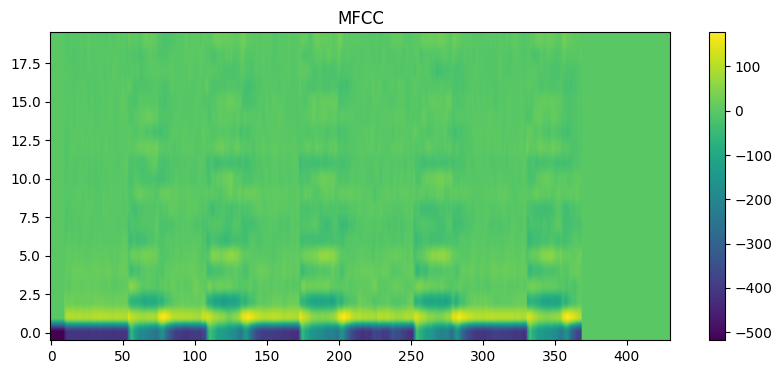

Epoch 1/20
98/98 [==============================] - 136s 1s/step - loss: 1.0069 - accuracy: 0.5459 - val_loss: 1.0108 - val_accuracy: 0.5460
Epoch 2/20
98/98 [==============================] - 122s 1s/step - loss: 0.6332 - accuracy: 0.7371 - val_loss: 0.7800 - val_accuracy: 0.6810
Epoch 3/20
98/98 [==============================] - 123s 1s/step - loss: 0.5102 - accuracy: 0.7950 - val_loss: 0.5529 - val_accuracy: 0.7989
Epoch 4/20
98/98 [==============================] - 127s 1s/step - loss: 0.4218 - accuracy: 0.8219 - val_loss: 0.6705 - val_accuracy: 0.7443
Epoch 5/20
98/98 [==============================] - 120s 1s/step - loss: 0.3820 - accuracy: 0.8353 - val_loss: 0.4369 - val_accuracy: 0.8247
Epoch 6/20
98/98 [==============================] - 123s 1s/step - loss: 0.3483 - accuracy: 0.8555 - val_loss: 0.6210 - val_accuracy: 0.7500
Epoch 7/20
98/98 [==============================] - 122s 1s/step - loss: 0.3217 - accuracy: 0.8673 - val_loss: 0.4307 - val_accuracy: 0.8448
Epoch 8/20
98

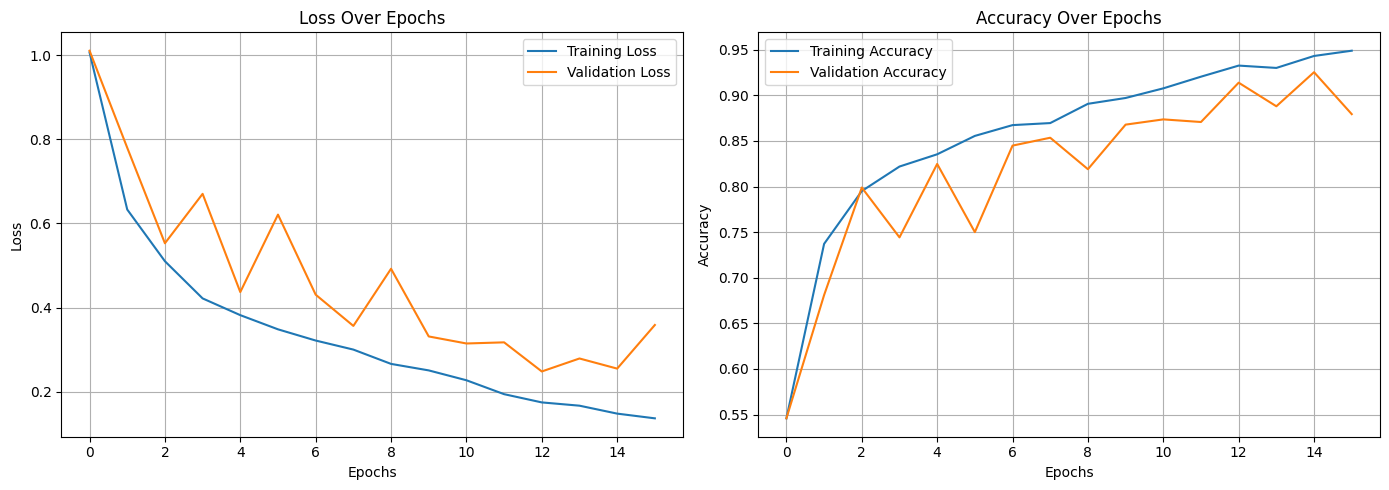

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import warnings

# 경고 메시지 억제
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 여러 개의 데이터 디렉토리
data_dirs = [
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DISTINCT',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy2',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/healthy3',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/add_noise',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/change_speed',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/pitch_shift',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/shift',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/DIS_AUG/time_stretch',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid1',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid2',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid3',
    '/content/drive/MyDrive/Colab Notebooks/voicedata/covid4',
]

# MFCC 파라미터
n_mfcc = 20
n_fft = 2048
hop_length = 512
duration = 10  # 각 오디오 파일의 길이 설정
sr = 22050  # 통일된 샘플링 레이트

# 고정된 MFCC 시퀀스 길이
fixed_sequence_length = int(np.ceil(duration * sr / hop_length))

# 데이터를 로드하고 MFCC로 변환하는 함수
def load_data(data_dirs, sr=22050):
    X, y = [], []
    class_labels = []

    for data_dir in data_dirs:
        for file_name in os.listdir(data_dir):
            file_path = os.path.join(data_dir, file_name)
            if os.path.isfile(file_path) and file_path.endswith('.wav'):
                try:
                    audio, _ = librosa.load(file_path, sr=sr, duration=duration)  # 지정된 샘플링 레이트로 변환
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

                # MFCC 시퀀스 길이를 고정된 길이로 맞추기
                if mfcc.shape[1] < fixed_sequence_length:
                    pad_width = fixed_sequence_length - mfcc.shape[1]
                    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    mfcc = mfcc[:, :fixed_sequence_length]

                X.append(mfcc)

                # 파일 이름의 첫 부분을 클래스 레이블로 사용
                class_label = file_name.split('(')[0]
                class_labels.append(class_label)

    # 클래스 레이블을 숫자로 변환
    class_labels_unique = list(set(class_labels))
    y = [class_labels_unique.index(lbl) for lbl in class_labels]

    return np.array(X), np.array(y), class_labels_unique

# 데이터 로드
X, y, class_labels_unique = load_data(data_dirs, sr=sr)

# 데이터 크기 및 분포 확인
print(f'Data shape: {X.shape}')
print(f'Class labels: {class_labels_unique}')

# 각 클래스의 데이터 개수 확인
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(class_labels_unique, counts))
print(f'Class distribution: {class_counts}')

# 데이터 시각화
plt.figure(figsize=(10, 4))
plt.imshow(X[0].squeeze(), aspect='auto', origin='lower')
plt.title('MFCC')
plt.colorbar()
plt.show()

# 데이터 크기 확인 및 조정
X = np.expand_dims(X, axis=-1)  # CNN은 4D 텐서를 입력으로 필요로 하므로 차원 추가

# 데이터를 학습 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 모델 정의
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(n_mfcc, fixed_sequence_length, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Reshape((fixed_sequence_length // 8, (n_mfcc // 8) * 128)),
    layers.Bidirectional(layers.GRU(128, return_sequences=True)),
    layers.Bidirectional(layers.GRU(128)),
    layers.Dropout(0.5),
    layers.Dense(len(class_labels_unique), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# 학습 곡선 시각화 함수
def plot_learning_curves(history):
    plt.figure(figsize=(14, 5))

    # 손실 함수 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 학습 곡선 시각화 호출
plot_learning_curves(history)
